![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot

# Réseaux de neurones

## Mise en situation
Toujours salarié à la poste, préposé aux algorithmes de reconnaissances des codes postaux :)

La permière version à base de régression logistique (cf. jour 9) était rapide et _plutôt_ efficace (~75%) mais trop loin de ce qu'on est en droit d'espérer comparé à un humain.

La seconde version à base de kNN (cf. jour 10) faisait du 95%, mais trop lente.

La version 3, qui mixait kNN et PCA (cf. jour 13) corrigeait un peu ce souci en réduisant la dimensionalité du problème. Mais sur des problèmes à beaucoup plus large échelle, le PCA permettra souvent de réduire les dimensions sans pour autant arriver au final à un nombre "raisonnable" de dimensions restantes. Ca sera parfois encore trop pour faire un modèle efficace à base de kNN+PCA.

Donc, retour à la case départ, grosse performance en temps et en précision, si possible.

## Un neurone
### Neurone biologique
Biologiquement parlant, le neurone est une cellule qui va :
* être excitée par un stimulus
* délivrer une charge de neurotransmetteurs si le stimulus dépasse un certain seuil

Ces neurotransmetteurs sont des stimuli pour d'autres neurones, et ainsi de suite.

Je ne suis pas spécialise en biologie donc je ne broderai pas plus que ça.

### Neurone artificiel
La définition biologique ressemble à un concept qu'on a déjà manipulé. Une fonction qui en entrée reçoit différentes informations, et qui les traite pour obtenir un résultat quasi binaire : c'est une régression logistique.

On a vu (cf. jour 15) qu'on pouvait résoudre un problème non-linéaire en empilant des régressions logistiques. On y a vu aussi que le modèle pouvait aussi se débrouiller pour trouver les régressions optimales à empiler.

## Réseau de neurones
### Définition du réseau de neurones à deux couches
On considère un système dans lequel on aurait certaines mesures en entrée et :
* $l_1$ modèles de regression logistique (on va dire neurones à partir de maintenant) qui travaillent sur toutes les mesures. C'est la première couche.
* $l_2$ neurones qui travaillent sur les $l_1$ sorties de la première couche.

Le XOR empilait deux couches avec 2 entrées $a$ et $b$, $l_1=1$, $l_2=2$, ici on a la même chose en plus générique.

En général, quand on fait une classification, $l_2$ est le nombre de classes différentes, on aura autant de neurones en dernière couche que de classes à reconnaitre : un neurone dédié à une classe. Ça permet aussi de ne pas entraîner 10 modèles logistiques pour reconnaître 10 chiffres différents, comme on a du le faire...

### Représentation du modèle
Certaines conventions changent, notamment:
* On ne va plus parler de $\theta$ avec un paramètre $\theta_0$ lié à une mesure virtuelle $x_0$ fixée à 1. A la place on a:
  * les poids _W_
  * le biais _b_
  * _b_ correspond peu ou prou à $\theta_0$ et _W_ aux autres paramètres
* _W_ n'est pas un vecteur, c'est une matrice
  * $\theta$ était un vecteur correspondant aux poids d'un seul neurone, _W_ est le jeu de poids de chaque neurone de la couche
  * _b_ n'est pas un scalaire mais un vecteur pour la même raison (un biais par neurone de la couche)
* _W_ et _b_ sont
  * définis par couche : on aura W1, b1, W2, b2
  * pour _W_, de taille L x L', avec L' la taille de la couche précédente et L la taille de la couche en cours
  * pour _b_, de taille L x 1
* Le jeu d'entrainement _X_ n'est plus "un exemple par ligne" mais "un exemple par colonne". De même _Y_ est un vecteur ligne désormais.

Ces changements arbitraires permettent de coder le tout de manière plus propre.

### Passe vers l'avant
A partir d'une donnée x, on va :
* pour chaque neurone de la couche 1
  * calculer la combinaison linéaire "x et poids du neurone", plus le biais, pour obtenir une valeur $z_1$ par neurone
  * calculer l'activation $a_1$ de ce neurone : le passage de $z_1$ à travers la fonction sigmoïde
* pour chaque neurone de la seconde couche, on va :
  * calculer la combinaison linéaire de "a et poids du neurone" plus le biais pour obtenir une valeur $z_2$ par neurone
  * calculer l'activation $a_2$ de ce neurone : le passage de $z_2$ à travers la fonction sigmoïde
  
Chaque couche fait à peu près pareil. Les données sont les entrées de la première, la sortie de la première est l'entrée de la seconde, et la sortie de la seconde est la sortie du modèle.

### Passe vers l'avant - version matricielle
On pourra calculer tout d'un coup, via les formules :
* Z1 = W1.X + b1
  * Donne une matrice "résultat par neurone de la couche et par exemple traité"
  * Un broadcast transformera b1 en matrice avec le bon nombre de colonnes, chacune étant égale à b1
* A1 = S(Z1)
  * On traite la sigmoide sur toute la matrice
* Z2 = W2.A1 + b2
* A2 = S(Z2)

### Passe vers l'arrière (rétropropagation du gradient)
Comme on l'a vu avec le XOR, dériver le coût n'est pas une mince affaire mais on peut le faire efficacement par étape via la formule de la composé de la dérivée. Et on va même trouver une relation de récurrence !

Le coût du modèle est toujours celui utilisé pour les classifications : $-\frac{1}{m}\sum\left[y.log(A2) + (1-y).log(1-A2)\right]$

On commence déjà par calculer la dérivée par rapport à A2 - notation : on appelera dX la dérivée de J partielle par rapport à X.

dA2 = $-\frac{1}{m}\left[\frac{y}{A2} - \frac{1-y}{1-A2}\right]$

Et on remonte à partir de là : dZ2, dW2, db2 etc...

* A2 = s(Z2)
  * dZ2 est $\frac{dJ}{dZ2}$, qui vaut $\frac{dJ}{dA2} * \frac{dA2}{dZ2}$, on va calculer la dérivée de A2 par rapport à Z2
  * dZ2 = dA2 * A2 * (1-A2) - la dérivée de la sigmoide est $\sigma'(x) = \sigma(x).(1-\sigma(x))$
* db2 = dZ2 - attention au broadcast ! on a copié b2 pour chaque exemple, en sens inverse il faut le sommer pour chaque exemple
* dW2 = dZ2.A1' - la transposée de A1
* dA1 = W2'.dZ2
* dZ1 = dA1 * A1 (1-A1) - cf ci-dessus
* db1 = dZ1 (sommé, cf. plus haut db2)
* dW1 = dZ1.X'

Et inutile de remonter plus haut, on n'a pas besoin de "corriger" les entrées X :)

Pour bien clarifier, on va écrire les dimensions :
* On note :
  * m nombre de données
  * n nombre de mesures par données
  * l nombre de neurones de la première couche
  * k nombre de classes
* On a en première couche
  * X de taille n x m
  * W1 de taille l x n
  * b1 de taille l x 1
  * Donc Z1 = W1.X+b1 de taille l x m (broadcast de b1 en l x m)
  * A1 de même taille que Z1 : l x m
* Puis en seconde couche
  * W2 de taille k x l
  * b2 de taille k x 1
  * Donc Z2 de taille k x m
  * Et A2 de taille k x m. Ca correspond bien à k réponses, pour chacun des m exemples.
* En marche arrière maintenant
  * dA2 est de taille k x m (broadcast de Y de 1 x m vers k x m)
  * dZ2 idem - c'est un produit élément par élément
  * dW2 est de dimension (k x m).(m x l) donc k x l
  * db2 est de dimension k x 1 (k x l mais sommé)
  * dA1 : l x m
  * dZ1 : idem
  * dW1 : l x n
  * db1 : l x 1 (broadcast inverse)
  
Tout va bien : les gradients sont de mêmes dimensions que les paramètres du modéle :-)

### Initialisation des W et b
La valeur de départ importe peu - pour l'instant. On convergera probablement. Par contre, il est impératif de "casser la symétrie" : si on met tous les W d'une couche à zéro ou même une constante non nulle, lors du retour du gradient on aura le même gradient sur chaque composante, et au final chaque neurone sera identique à quelque nombre d'itération que ce soit.

Exemple avec le XOR : je sais que le modèle va, mettons, calculer (A ou B) et (!A ou !B) dans la couche intermédiaire. Pour y arriver, il va prendre celui des deux neurones qui est le plus "proche" de la première opération et l'ajuster en fonction, et idem pour la seconde. Si on est à l'équilibre parfait, on est en plein dans la variante ML de l'âne de Buridan : impossible de choisir entre l'eau et l'avoine, le système restera à l'équilibre.

Une fois le point de départ défini, tout le système est entierement déterministe : il faut donc un point de départ qui permette d'arriver au point de convergence, mais on n'a aucune raison de faire évoluer un neurone plutôt qu'un autre s'ils ont les mêmes gradients de retours. Avec certaines méthodes anti-overfit comme le dropout par exemple, on verra plus tard que le déterminisme peut être cassé.

En tous les cas, une initialisation aléatoire des W est nécessaire. Il existe quelques optimisations pour faire converger plus vite, mais pareil on verra ça dans les jours suivants.

Concernant les _b_, mettre des 0 suffit pour le coup : les poids sont importants, le biais n'est qu'une variable d'ajustement pour minimiser un écart constant.

## Simulation rapide

Validons rapidement le concept avec un exemple rapide : le XOR. On sait que ça marche puisqu'on l'a déjà fait par ailleurs.

La fonction *double_layer_model* va entrainer ce modèle comme on a l'habitude de le faire : descente de gradient, mini batch, etc...

In [2]:
def sigmoid(x) : return 1 / (1 + np.exp(-x))

def double_layer_model(X, Y, mid_layer, class_count, learning_rate = 0.0075, num_iterations = 3000, batch_size = 64):

    m = X.shape[1]
    batchStart = 0
    costs = []

    W1 = np.random.rand(mid_layer, X.shape[0])
    b1 = np.zeros((mid_layer, 1))
    W2 = np.random.rand(class_count, mid_layer)
    b2 = np.zeros((class_count, 1))


    for i in range(1, num_iterations+1):
        Xbatch = X[:,batchStart:batchStart + batch_size]
        Ybatch = Y[:,batchStart:batchStart + batch_size]
        
        # Passe en avant
        Z1 = np.dot(W1, Xbatch) + b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(W2, A1) + b2
        A2 = sigmoid(Z2)
        
        # Calcul du cout (juste pour voir)
        cost = np.squeeze(-np.sum(np.log(A2) * Ybatch + np.log(1 - A2) * (1-Ybatch))/Xbatch.shape[1])
        if i % (num_iterations // 100) == 0:
            costs.append(cost)
        if i % (num_iterations // 20) == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

        dA2 = -(np.divide(Ybatch, A2) - np.divide(1 - Ybatch, 1 - A2))/Xbatch.shape[1]
        dZ2 = dA2 * A2 * (1 - A2)
        dW2 = np.dot(dZ2, A1.T)
        db2 = np.sum(dZ2, axis=1, keepdims = True)
        
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = dA1 * A1 * (1 - A1)
        dW1 = np.dot(dZ1, Xbatch.T)
        db1 = np.sum(dZ1, axis=1, keepdims = True)
        
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

        batchStart += batch_size
        if batchStart >= X.shape[1]: batchStart = 0
        
    return W1, b1, W2, b2, costs

def model(X, W1, b1, W2, b2) :
        Z1 = np.dot(W1, X) + b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(W2, A1) + b2
        A2 = sigmoid(Z2)
        return A2

On y va pour l'entrainement : un XOR. On sait qu'il faut 2 neurones dans la première couche, et qu'il n'y a qu'une réponse donc une seule classe de sortie

Cost after iteration 100: 0.692126
Cost after iteration 200: 0.685371
Cost after iteration 300: 0.631033
Cost after iteration 400: 0.500277
Cost after iteration 500: 0.235959
Cost after iteration 600: 0.089350
Cost after iteration 700: 0.050119
Cost after iteration 800: 0.034105
Cost after iteration 900: 0.025642
Cost after iteration 1000: 0.020463
Cost after iteration 1100: 0.016986
Cost after iteration 1200: 0.014499
Cost after iteration 1300: 0.012634
Cost after iteration 1400: 0.011187
Cost after iteration 1500: 0.010032
Cost after iteration 1600: 0.009090
Cost after iteration 1700: 0.008307
Cost after iteration 1800: 0.007646
Cost after iteration 1900: 0.007082
Cost after iteration 2000: 0.006593


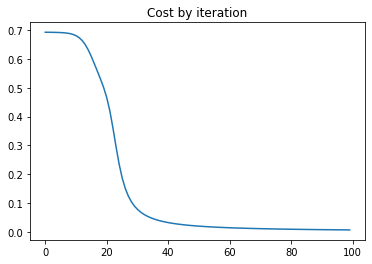

In [3]:
np.random.seed(1)
x = np.array([[0,0],[0,1],[1,0],[1,1]]).T
y = np.array([[0,1,1,0]])
W1, b1, W2, b2, costs = double_layer_model(x, y, 2,1, learning_rate = 1, num_iterations = 2000)

plot.title('Cost by iteration')
plot.plot(range(100), costs)
plot.show()

Et maintenant on valide le détail :

In [4]:
xor_result = model(x, W1, b1, W2, b2)
for i in range(4):
    print("%i xor %i = %i" %(x[0,i], x[1,i], xor_result[0,i]>.5))

0 xor 0 = 0
0 xor 1 = 1
1 xor 0 = 1
1 xor 1 = 0


## Retour à la mise en situation

### Chargement des données

Les données sont les même que d'habitude. Elles proviennent du dataset de Yann Le Cun http://yann.lecun.com/exdb/mnist/

Il s'agit d'images 28x28, 60.000 données d'entrainement et 10.000 données de validation.

In [5]:
def load(file): 
    data = np.load(file)
    return data['x'], data['y']

x_train, y_train = load('data/d09_train_data.npz')
x_test , y_test  = load('data/d09_test_data.npz')

m,n = x_train.shape

print('%i training samples loaded of size %i' % (m, n))
print('%i test samples loaded' %(x_test.shape[0]))

60000 training samples loaded of size 784
10000 test samples loaded


On normalise (very important !) et on construit une matrice de résultat au lieu d'un vecteur de valeurs

In [6]:
mus = x_train.mean(axis = 0)
sigmas = x_train.std(axis = 0)
x_train_norm = (x_train-mus)/(1e-9 +sigmas)
y_train_mat = (y_train == np.arange(10)).astype(int)

On y va pour l'entrainement : reste à trouver la valeur de neurones adéquate pour la première couche.

Il n'y a pas vraiment de méthode. En général, plus il y en a et mieux c'est : au pire le système ignorera les neurones inutiles. Par contre, ça prendra plus de temps.

Cost after iteration 1000: 1.238752
Cost after iteration 2000: 0.997574
Cost after iteration 3000: 0.974595
Cost after iteration 4000: 0.697858
Cost after iteration 5000: 0.731749
Cost after iteration 6000: 0.505472
Cost after iteration 7000: 0.523882
Cost after iteration 8000: 0.809232
Cost after iteration 9000: 0.347687
Cost after iteration 10000: 0.535144
Cost after iteration 11000: 0.099107
Cost after iteration 12000: 0.932439
Cost after iteration 13000: 0.543279
Cost after iteration 14000: 0.624429
Cost after iteration 15000: 0.333379
Cost after iteration 16000: 0.301502
Cost after iteration 17000: 0.243928
Cost after iteration 18000: 0.212076
Cost after iteration 19000: 0.334557
Cost after iteration 20000: 0.166549


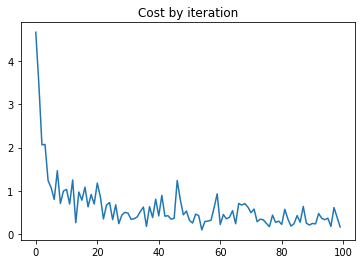

In [7]:
np.random.seed(1)
W1, b1, W2, b2, costs = double_layer_model(x_train_norm.T, y_train_mat.T, 50, 10, learning_rate = 1
                                      , num_iterations = 20000)
plot.title('Cost by iteration')
plot.plot(range(100), costs)
plot.show()

Note : le coût ne décroit pas en permanence: un peu à cause de $\alpha$, et un peu aussi parce que c'est du mini batch. Regardons le résultat :

In [8]:
# On calcule la matrice de résultat
y_model_train = model(x_train_norm.T, W1, b1, W2, b2)

# On la transforme en vecteur de valeurs
y_train_result = np.argmax(y_model_train, axis = 0).reshape(-1, 1)

# Et on calcule le ratio
train_ratio = np.mean(y_train_result == y_train)

print("Accuracy on training set : %f%%" % (100 * train_ratio))

Accuracy on training set : 94.720000%


Et bien entendu, on va faire pareil sur le jeu de test :

In [9]:
x_test_norm = (x_test - mus)/(1e-9 + sigmas)

# On calcule la matrice de résultat
y_model_test = model(x_test_norm.T, W1, b1, W2, b2)

# On la transforme en vecteur de valeurs
y_test_result = np.argmax(y_model_test, axis = 0).reshape(-1, 1)

# Et on calcule le ratio
test_ratio = np.mean(y_test_result == y_test)

print("Accuracy on test set : %f%%" % (100 * test_ratio))

Accuracy on test set : 91.310000%


Une précision de 91.31%. C'est vraiment pas mal ! En tous les cas bien mieux que le 70% d'une simple régression logistique ! Affichons quelques erreurs pour voir.

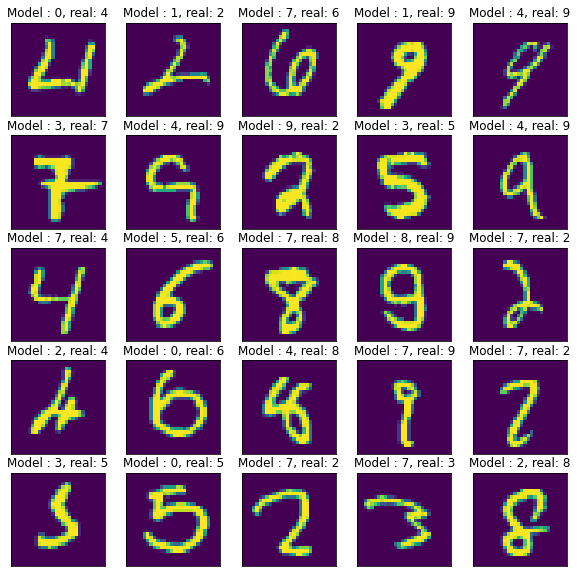

In [10]:
wrong_indices_samples = np.argwhere(y_test_result != y_test)[:25, 0]

fig = plot.figure(figsize=(10,10))
for i in range(25):
    axes = fig.add_subplot(5,5,1+i)
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
    index = wrong_indices_samples[i]
    plot.imshow(x_test[index, :].reshape(28,28))
    plot.title('Model : %i, real: %i'% (y_test_result[index], y_test[index]))

Il existe un critère simple pour savoir si on peut encore faire mieux : est-ce que moi, être humain, j'y arrive?

Si la réponse est oui, on peut progresser un peu plus. Ou en tous les cas, on sait qu'il est possible de faire mieux et il va falloir trouver comment. On verra quelques outils plus tard, pour dépasser 95%.